# Dados de Cotações

In [2]:
#Importando pacotes
import pandas as pd
import numpy as np
from urllib.request import urlopen
#import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import mstats
warnings.filterwarnings("ignore")

In [3]:
#Descriminando URL de download
url = "https://api.data.economatica.com/1/oficial/datafeed/download/1/oph2LwwiMazuUGjnIuvaibnn%2FLjwrYvs8KW6mxzexjUfc8IXEks1lhwSCNFbVOPf7Kq7k9Ji2icHCj%2BSqTJXZ1V6vxP5eTCjxv2RFETGy6YTlL8gHyw7A7%2BOSCmxQJdlzQYuYjQNL9s6OxAYU48TECrFsZxv%2BSiPZtDHAKiUqi2tS1t5s6V6L1zuWQJ7J1FPvrYivO3JxEZI1kHXWpNKWxy9yQmbPGDbxS6SFMnlmB7Dy86NsSc0V44FV5F0RYZouEbs7FUpVdrxjPHQicvy3WOv8aoS7fnA3M8FDORc2lP5SMPQMNv1BBXWklLoaWiRY93RFFWaY%2BnRR4ouaKgwZQ%3D%3D"
indices = "https://api.data.economatica.com/1/oficial/datafeed/download/1/jIFbIzZ6mj3itlfxKk9y5RW6yi7UT2OuKsIfrip3AbmQn3hIqrNgLKl0NmC3dkb5S4JISEgAD2dNFmrBs7bH%2BSOq4iCd%2FRwDRm9p5x7rtnWyUFAzJJJBQmUMeM48%2BzvYDrkHNHFEkvWGM4ifq%2BJ48jfgvk7dn%2BVGUKkcZxI4FjA4yXM%2FoFjWVpwgeOLBLs%2FpCuttUBMntHZfSWm%2BQv2BR9t%2FwlQPJyvEyvzldFtsC6ugE%2B4EOxGywjw1%2B037t2j0UxZTHoJr1Z4f%2FCXO%2BXGUi1FP7xepIiAmnQLxs3bS8uR9lcTWeRQh9P6EbuqfEY8OC1lz%2B0kAgwoRe65rWMZYHQ%3D%3D"

In [4]:
#%%time
#Abrindo a base
data = pd.read_csv(urlopen(url),encoding='latin-1')
#Retirando sufixo
data['Ativo']=data['Ativo'].str.rstrip('<XBSP>')
#Declarando coluna data como datatime
data['Data'] = pd.to_datetime(data['Data'])
#Renomeando colunas
data.columns = ['ativo','data',"fech","abt","min","max","pmed","qnegs","qtits","volume"]

In [5]:
#Confirmando o número de empresas
unique=data['ativo'].unique()
#unique
len(unique)

408

In [5]:
#data

In [6]:
#Declarando hifens como dados faltantes NAN
data[data == "-"] = np.nan
#Preenchendo valores ausentes (médoto para frente (ffill))
data = data.set_index('ativo', append=True)
data = data.groupby(level=1).ffill()
data = data.reset_index(level=1)

In [7]:
data=data.sort_values(['data', "ativo"], ascending=[True, True])
#data.head(40)

In [8]:
#IBOV que  ira auxiliar em construir um índice com datas do último dia do mês para o calendário brasileiro
#Abrindo a base
indice = pd.read_csv(urlopen(indices),encoding='latin-1')
#Retirando sufixo
indice['Ativo']=indice['Ativo'].str.rstrip('<XBSP>')
#Base somente com o IBOV
ibov=indice[indice['Ativo']=='IBOV'].iloc[:,:3]
#Declarando coluna data como datatime
ibov['Data'] = pd.to_datetime(ibov['Data'])
#Declarando hifens como dados faltantes NAN
ibov[ibov=='-']=np.nan
#Excluindo NAN (dias que a B3 não abriu)
ibov=ibov.dropna()
#Renomeia colunas
ibov.columns = ['ativo','data','fech']
#Identificando o último dia de cada mês
groups = ibov.groupby([ibov['data'].dt.year, ibov['data'].dt.month])['data']
last = []
for idx, group in groups:
    y = last.append(group.iloc[-1])
#last

In [9]:
index=pd.DataFrame({'data':last}) #usando a lista definida acima

In [10]:
#Marcando a última data disponível no objeto index e comparando com o ultimo dia do mês
import datetime
import calendar
from pandas.tseries.offsets import BMonthEnd
from pandas.tseries.offsets import BDay

today = datetime.date.today()
offset = BMonthEnd()
lastdaymt = offset.rollforward(today)
#lastdaymt_ifdec = offset.rollforward(today) - BDay(1)

#VERIFICA SE O ULTIMO DIA DO MÊS SERÁ 31 PARA O CASO DE DEZEMBRO, E APLICA A FORMULA CORRETA (TODOS OS MESES SERÃO A MESMA, EXCETO DEZEMBRO)
if (lastdaymt.day == 31) & (lastdaymt.month ==12):
    lastdaymt = offset.rollforward(today) - BDay(1)
else:
    lastdaymt = offset.rollforward(today)


#Preparando dataframe de referência onde todos ativos terão todas as datas de fim de mês
index=pd.DataFrame({'data':last}) #usando a lista definida acima#



if (index.iloc[-1][0] != lastdaymt):
    index=index[:-1] #tirando o mês que ainda não terminou
else:
    index=index
    
indexx=pd.concat([index]*len(unique), ignore_index=True)
listaativo=np.repeat(unique,len(index))
indexx['ativo']=listaativo
indexx

,data,ativo
0,2001-11-30,RRRP3
1,2001-12-28,RRRP3
2,2002-01-31,RRRP3
3,2002-02-28,RRRP3
4,2002-03-28,RRRP3
...,...,...
102403,2022-05-31,YDUQ3
102404,2022-06-30,YDUQ3
102405,2022-07-29,YDUQ3
102406,2022-08-31,YDUQ3


In [11]:
#Unindo a base de data/ativo completo com a base de dados (aparecerão Nan's nas datas sem valor)
price=pd.merge(indexx, data, how="left", on=["ativo", "data"])
#price

In [12]:
#Salvando em excel
price.to_excel('data.xlsx')

In [13]:
#MATRIZ IBRX
ibrx=pd.read_excel('ibrx.xlsx', sheet_name='Sheet1', index_col='Data')
#ibrx

In [14]:
#Verificando igualdade de número de ativos
len(list(ibrx.columns))==len(unique)

False

In [15]:
#Verificando igualdade de NÚMERO de datas (o "-1" tira o mês de novembro de 2001 que tem incluído nos links mas não no IBRX)
len(list(ibrx.index))==len(index)-1

False

In [16]:
#Preparando dataframe de referência do IBRX com data e ativos empilhados
empilhados=pd.Series(ibrx.values.ravel('F'))#Empilhando colunas do dataframe
indexibrx=pd.DataFrame({'data':list(ibrx.index)}) #Criando um índice
indexxibrx=pd.concat([indexibrx]*len(list(ibrx.columns)), ignore_index=True)
listaativo=np.repeat(list(ibrx.columns),len(indexibrx))
indexxibrx['ativo']=listaativo
indexxibrx['IBRX']=empilhados

In [17]:
#Verificando igualdade entre datas do IBRX empilhadp e da base DATA
list(indexibrx['data'])==list(index.loc[1:,'data'])

False

In [97]:
data

,ativo,data,fech,abt,min,max,pmed,qnegs,qtits,volume
55510,AALR3,2001-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10890,ABCB4,2001-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86071,ABEV3,2001-11-30,0.67703720192,0.6853956779,0.67703720192,0.6853956779,0.68026357405,8,738,1001.0505
1533263,ABRE11,2001-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16335,ABYA3,2001-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1812157,VULC3,2022-10-13,13.71,13.55,13.34,13.93,13.73,1678,277.6,3811.825
1817602,WEGE3,2022-10-13,33.47,33.58,33.04,34,33.54,21841,6121.1,205329.74
1824482,WEST3,2022-10-13,1.2,1.26,1.16,1.26,1.2,1321,1118.4,1348.889
1829927,WIZS3,2022-10-13,7.99,7.86,7.77,8.04,7.92,2678,582.3,4614.948


In [77]:
ibra = pd.read_excel(r'C:\Users\Cautela\Desktop\ZULT\Modelo\ibra\ibra1.xlsx')
ibram = ibra.melt(id_vars = 'Data')
#pd.concat([price['data'],ibrm['Data']], axis = 1)
ibram.columns = ['data','ativo','IBRA']
price_ibra = price.merge(ibram, how = 'left').fillna(0)

#import seaborn as sns
#sns.heatmap(price_ibra[price_ibra['ativo']=='ABEV3'].set_index('data')[['IBRA']].T)

In [94]:
ibram

,data,ativo,IBRA
0,2011-04-29,AALR3,0
1,2011-05-31,AALR3,0
2,2011-06-30,AALR3,0
3,2011-07-29,AALR3,0
4,2011-08-31,AALR3,0
...,...,...,...
43879,2022-05-31,YDUQ3,1
43880,2022-06-30,YDUQ3,1
43881,2022-07-29,YDUQ3,1
43882,2022-08-31,YDUQ3,1


In [82]:
ibrx = pd.read_excel(r'C:\Users\Cautela\Desktop\ZULT\Modelo\ibra\ibrx1.xlsx')
ibrxm = ibrx.melt(id_vars = 'Data')
#pd.concat([price['data'],ibrm['Data']], axis = 1)
ibrxm.columns = ['data','ativo','IBRX']
ibrxm
price_ibrx = price_ibra.merge(ibrxm, how = 'left').fillna(0)

In [86]:
#Unindo base de dados com IBRX
price1 = price_ibrx
#price1=pd.merge(price_ibra,indexxibrx,  how="left", on=["ativo", "data"])

In [87]:
#formato das variáveis
price1.dtypes

data      datetime64[ns]
ativo             object
fech              object
abt               object
min               object
max               object
pmed              object
qnegs             object
qtits             object
volume            object
IBRA             float64
IBRX             float64
dtype: object

In [111]:
#Formatando variáveis
price1['ativo'] = price1['ativo'].astype(str)
price1.iloc[:,2:] = price1.iloc[:,2:].astype(float)
price1.dtypes

data      datetime64[ns]
ativo             object
fech             float64
abt              float64
min              float64
max              float64
pmed             float64
qnegs            float64
qtits            float64
volume           float64
IBRA             float64
IBRX             float64
dtype: object

In [95]:
#Base de dados com participantes do IBRX 
#price2=price1[price1['IBRX']==1]
price2=price1
price2

,data,ativo,fech,abt,min,max,pmed,qnegs,qtits,volume,IBRA,IBRX
0,2001-11-30,RRRP3,0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.0,0.0
1,2001-12-28,RRRP3,0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.0,0.0
2,2002-01-31,RRRP3,0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.0,0.0
3,2002-02-28,RRRP3,0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.0,0.0
4,2002-03-28,RRRP3,0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
102403,2022-05-31,YDUQ3,16.18,16.46,16.11,16.80,16.34,9032.0,2423.5,39627.246,1.0,1.0
102404,2022-06-30,YDUQ3,13.07,13.30,12.82,13.32,13.10,13509.0,2498.6,32744.498,1.0,1.0
102405,2022-07-29,YDUQ3,13.25,13.60,13.11,13.63,13.25,6725.0,1684.4,22329.053,1.0,1.0
102406,2022-08-31,YDUQ3,12.31,12.75,12.21,12.78,12.39,7435.0,2462.8,30525.485,1.0,1.0


## Análise Exploratória de Dados

### Missing data

In [90]:
#Métricas para análise explanatória inicial
def estats(df):
    a=list(df.count()) #nonnullvalues
    
    b=list(df.isnull().sum() * 100 / len(df)) #percent_missing
   
    c = []#firstnonnullline
    for i in df.columns:
        y = df[i].first_valid_index()
        c.append(y) 
   
    d = [] #date_firstnonnullline
    for i in c:
        try:
            y = df.loc[i,'data']
            d.append(y)
        except Exception:
            y = np.nan
            d.append(y)

    e = [] #uniquevalues
    for i in df.columns:
        y = df[i].nunique()
        e.append(y)

    f= list(map(lambda x,y: (x/y)*100, e,a)) #percentunique

    g = [] #zerocount
    for i in df.columns:
        y = (df[i] == "0").sum()
        g.append(y)
    
    h= list(map(lambda x,y: (x/y)*100, g,a)) #percentzero   
    
    #Selecionando algumas métricas mais relevantes
    estats=pd.DataFrame(data={'percent_missing': b, 'date_firstnonnullline': d, 'percentunique':f, 'percentzero':h },index=df.columns)
    
    return estats.iloc[3:,:] #mostrando as métricas somente para as variáveis de fato

In [91]:
#Mostrando as métricas para toda base de dados
estats(price2)

,percent_missing,date_firstnonnullline,percentunique,percentzero
abt,0.0,2001-11-30,46.209281,0.0
min,0.0,2001-11-30,46.248340,0.0
max,0.0,2001-11-30,46.265917,0.0
pmed,0.0,2001-11-30,46.762948,0.0
qnegs,0.0,2001-11-30,12.744122,0.0
qtits,0.0,2001-11-30,32.468167,0.0
volume,0.0,2001-11-30,49.466839,0.0
IBRA,0.0,2001-11-30,0.001953,0.0
IBRX,0.0,2001-11-30,0.001953,0.0


In [24]:
#Olhando para um ticher em especial
#price2[price2['Ativo']=='ABEV3']

In [25]:
#Olhando para uma data em especial
#price2[price2['Data']=='2001-12-28']

In [26]:
#Mostrando as métricas para um ticker em especial
#estats(price2[price2['Ativo']=='VIVT3'])

In [28]:
#Mostrando as métricas para todos os tickers
# todos= list(map(lambda x: estats(price2[price2['ativo']==x]), list(price2['ativo'].unique())))
# estatsall=pd.concat(todos, axis=0, keys=list(price2['ativo'].unique()))
# estatsall

In [ ]:
#Análise visual de missing
#df=price2.copy()
#df = df.sort_values(by=['Data'])

#fontsize =12
    
#fig, ax = plt.subplots(1, 1, figsize=[5.5, 5.5]) #mude aqui o tamanho da matriz
#msno.matrix(df=df.iloc[:,3:], ax=ax, color=(0.2, 0.2, 0.2), sparkline=False, fontsize=fontsize)

#label = list(df['Data'].unique())
#ylim_start, ylim_end = ax.get_ylim()
#step_size = df.shape[0] / len(label)
#_ = ax.yaxis.set_ticks(np.arange(ylim_end, ylim_start, step_size))
#_ = ax.yaxis.set_ticklabels(label, fontsize=fontsize)

In [ ]:
#Outra análise visual de missing

#sns.heatmap(price2.isnull(), cbar=False)
#sns.heatmap(price2.isnull(), cbar=False,yticklabels=list(price2['Ativo']))

In [92]:
price2

,data,ativo,fech,abt,min,max,pmed,qnegs,qtits,volume,IBRA,IBRX
0,2001-11-30,RRRP3,0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.0,0.0
1,2001-12-28,RRRP3,0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.0,0.0
2,2002-01-31,RRRP3,0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.0,0.0
3,2002-02-28,RRRP3,0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.0,0.0
4,2002-03-28,RRRP3,0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
102403,2022-05-31,YDUQ3,16.18,16.46,16.11,16.80,16.34,9032.0,2423.5,39627.246,1.0,1.0
102404,2022-06-30,YDUQ3,13.07,13.30,12.82,13.32,13.10,13509.0,2498.6,32744.498,1.0,1.0
102405,2022-07-29,YDUQ3,13.25,13.60,13.11,13.63,13.25,6725.0,1684.4,22329.053,1.0,1.0
102406,2022-08-31,YDUQ3,12.31,12.75,12.21,12.78,12.39,7435.0,2462.8,30525.485,1.0,1.0


In [93]:
#Salvando em excel
price2.to_excel('cot.xlsx')

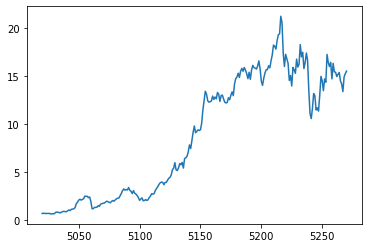

In [169]:
ax = price2[price2['ativo']=='ABEV3']['fech'].plot()

for container in ax.containers:
    ax.bar_label(ax.containers[0])